<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Check Missing Values
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [ ]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [ ]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333


In [ ]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [ ]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




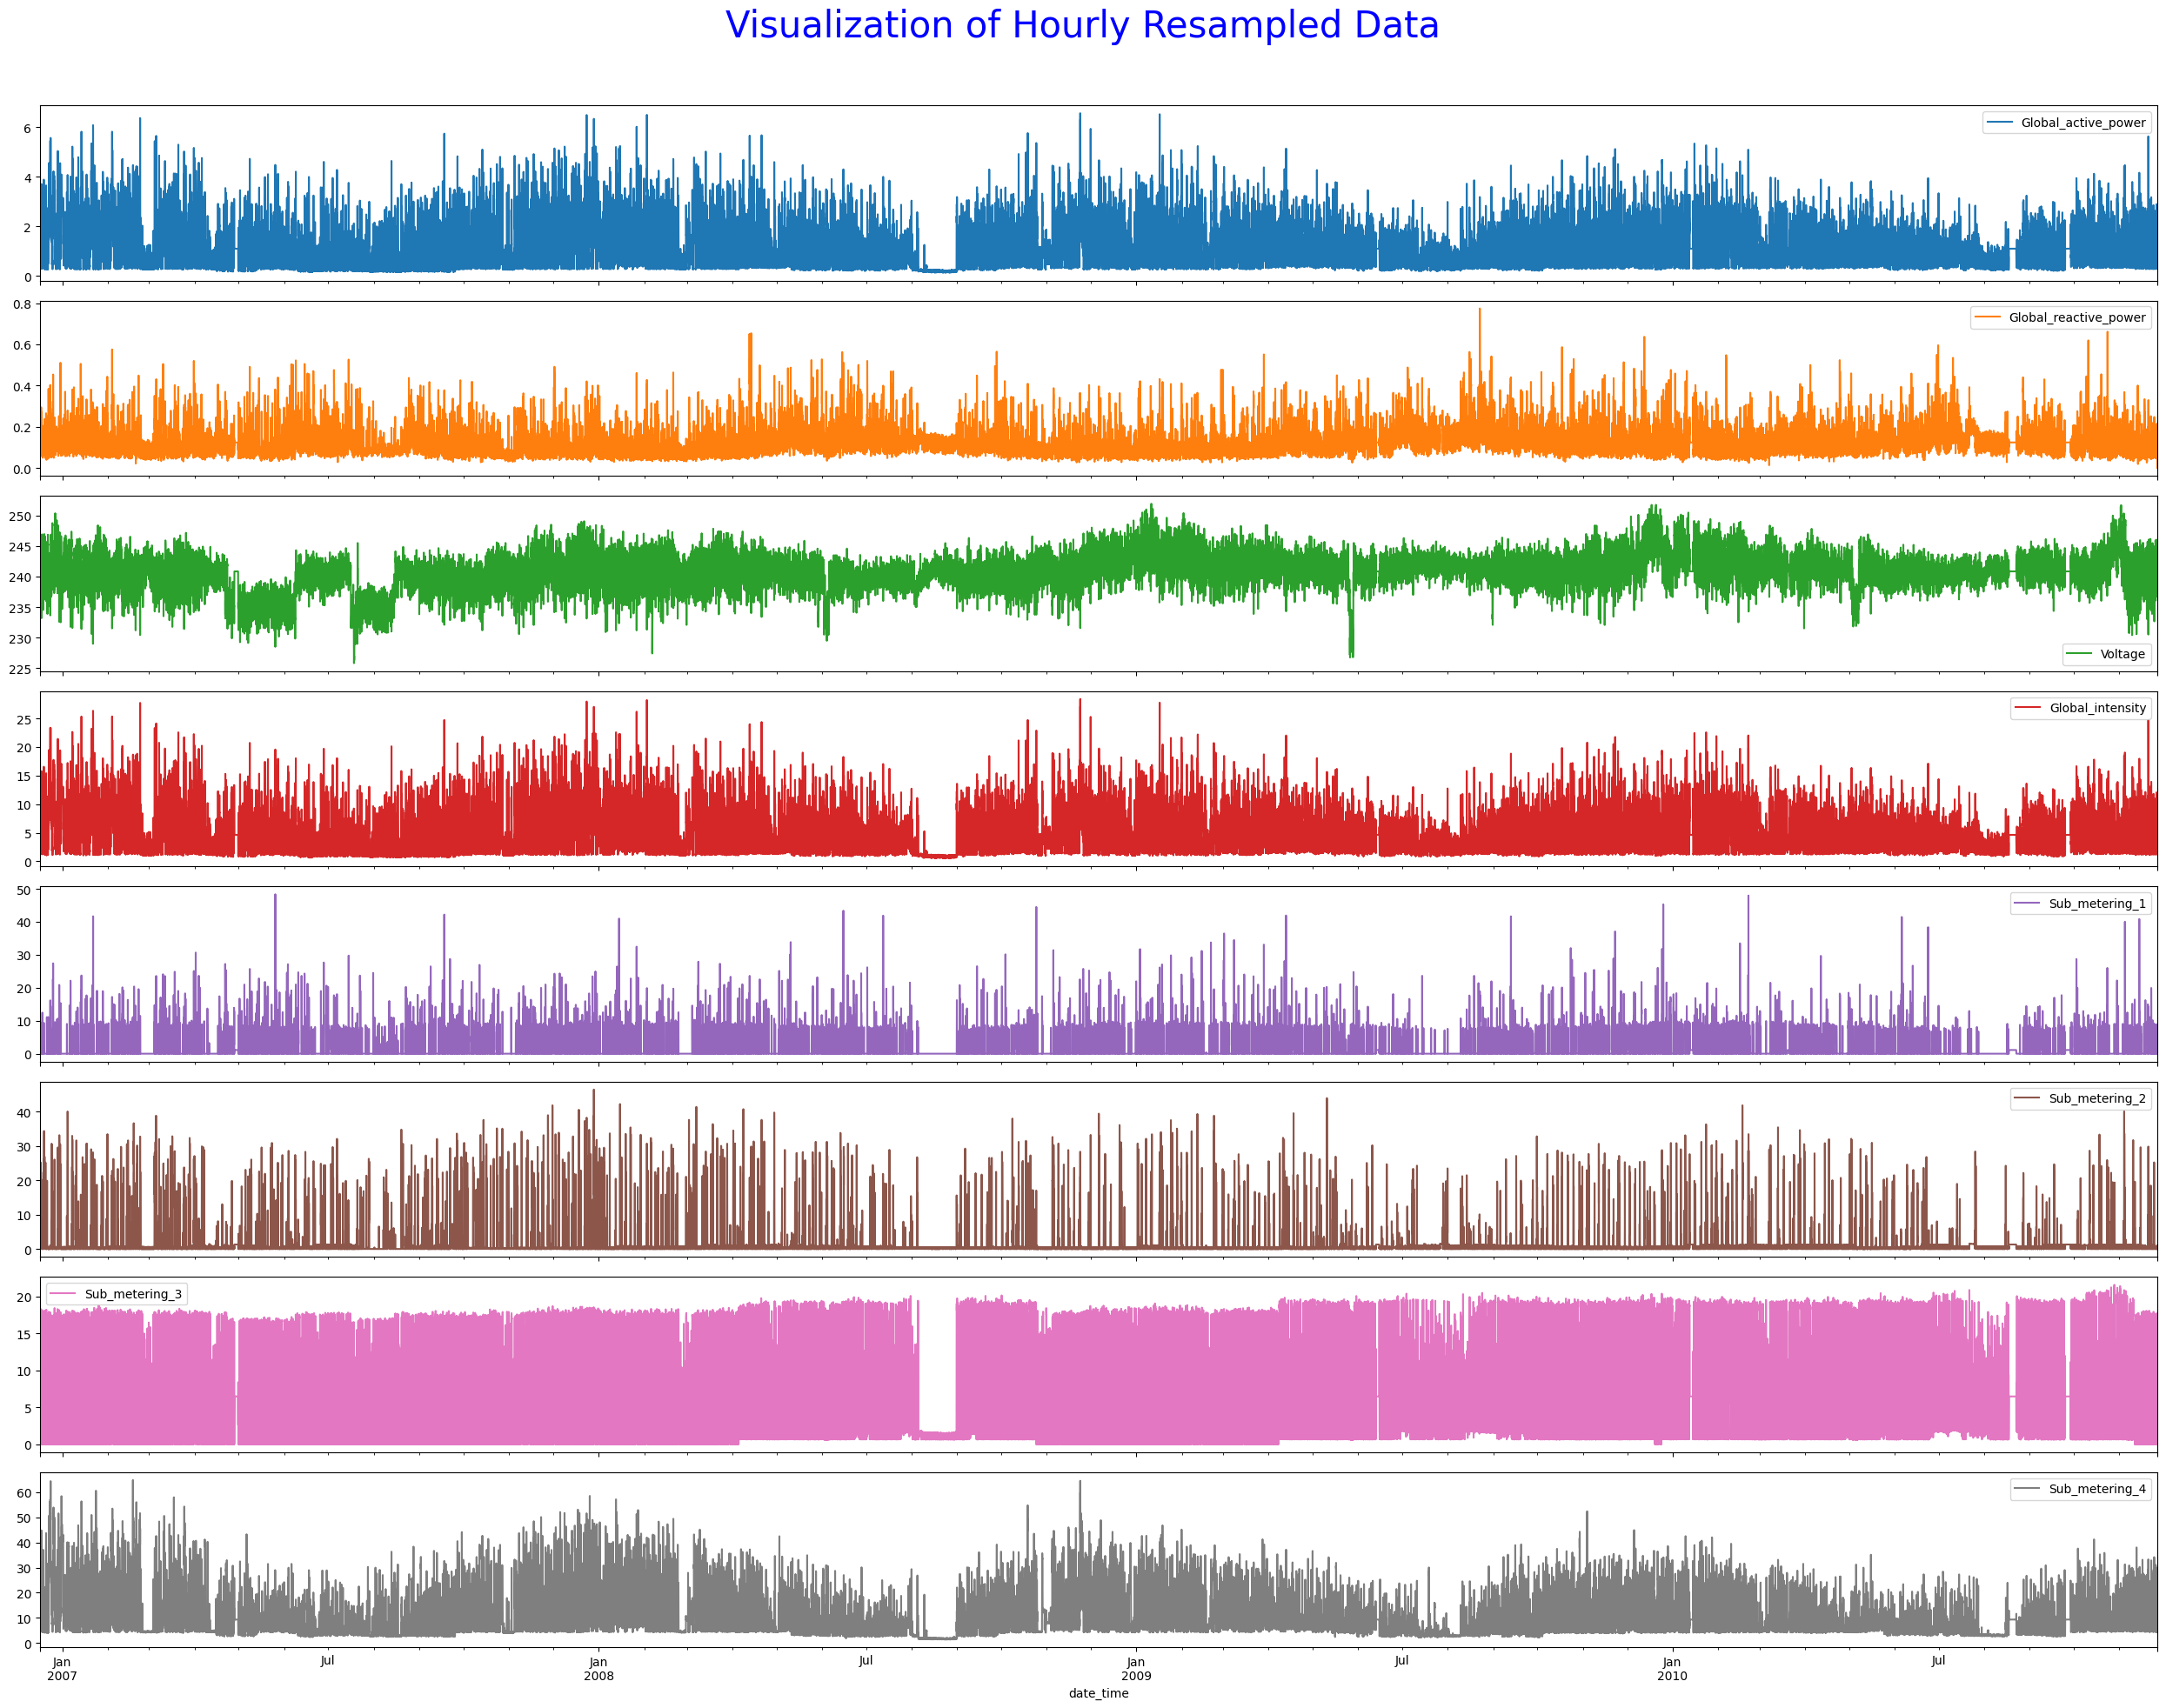

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



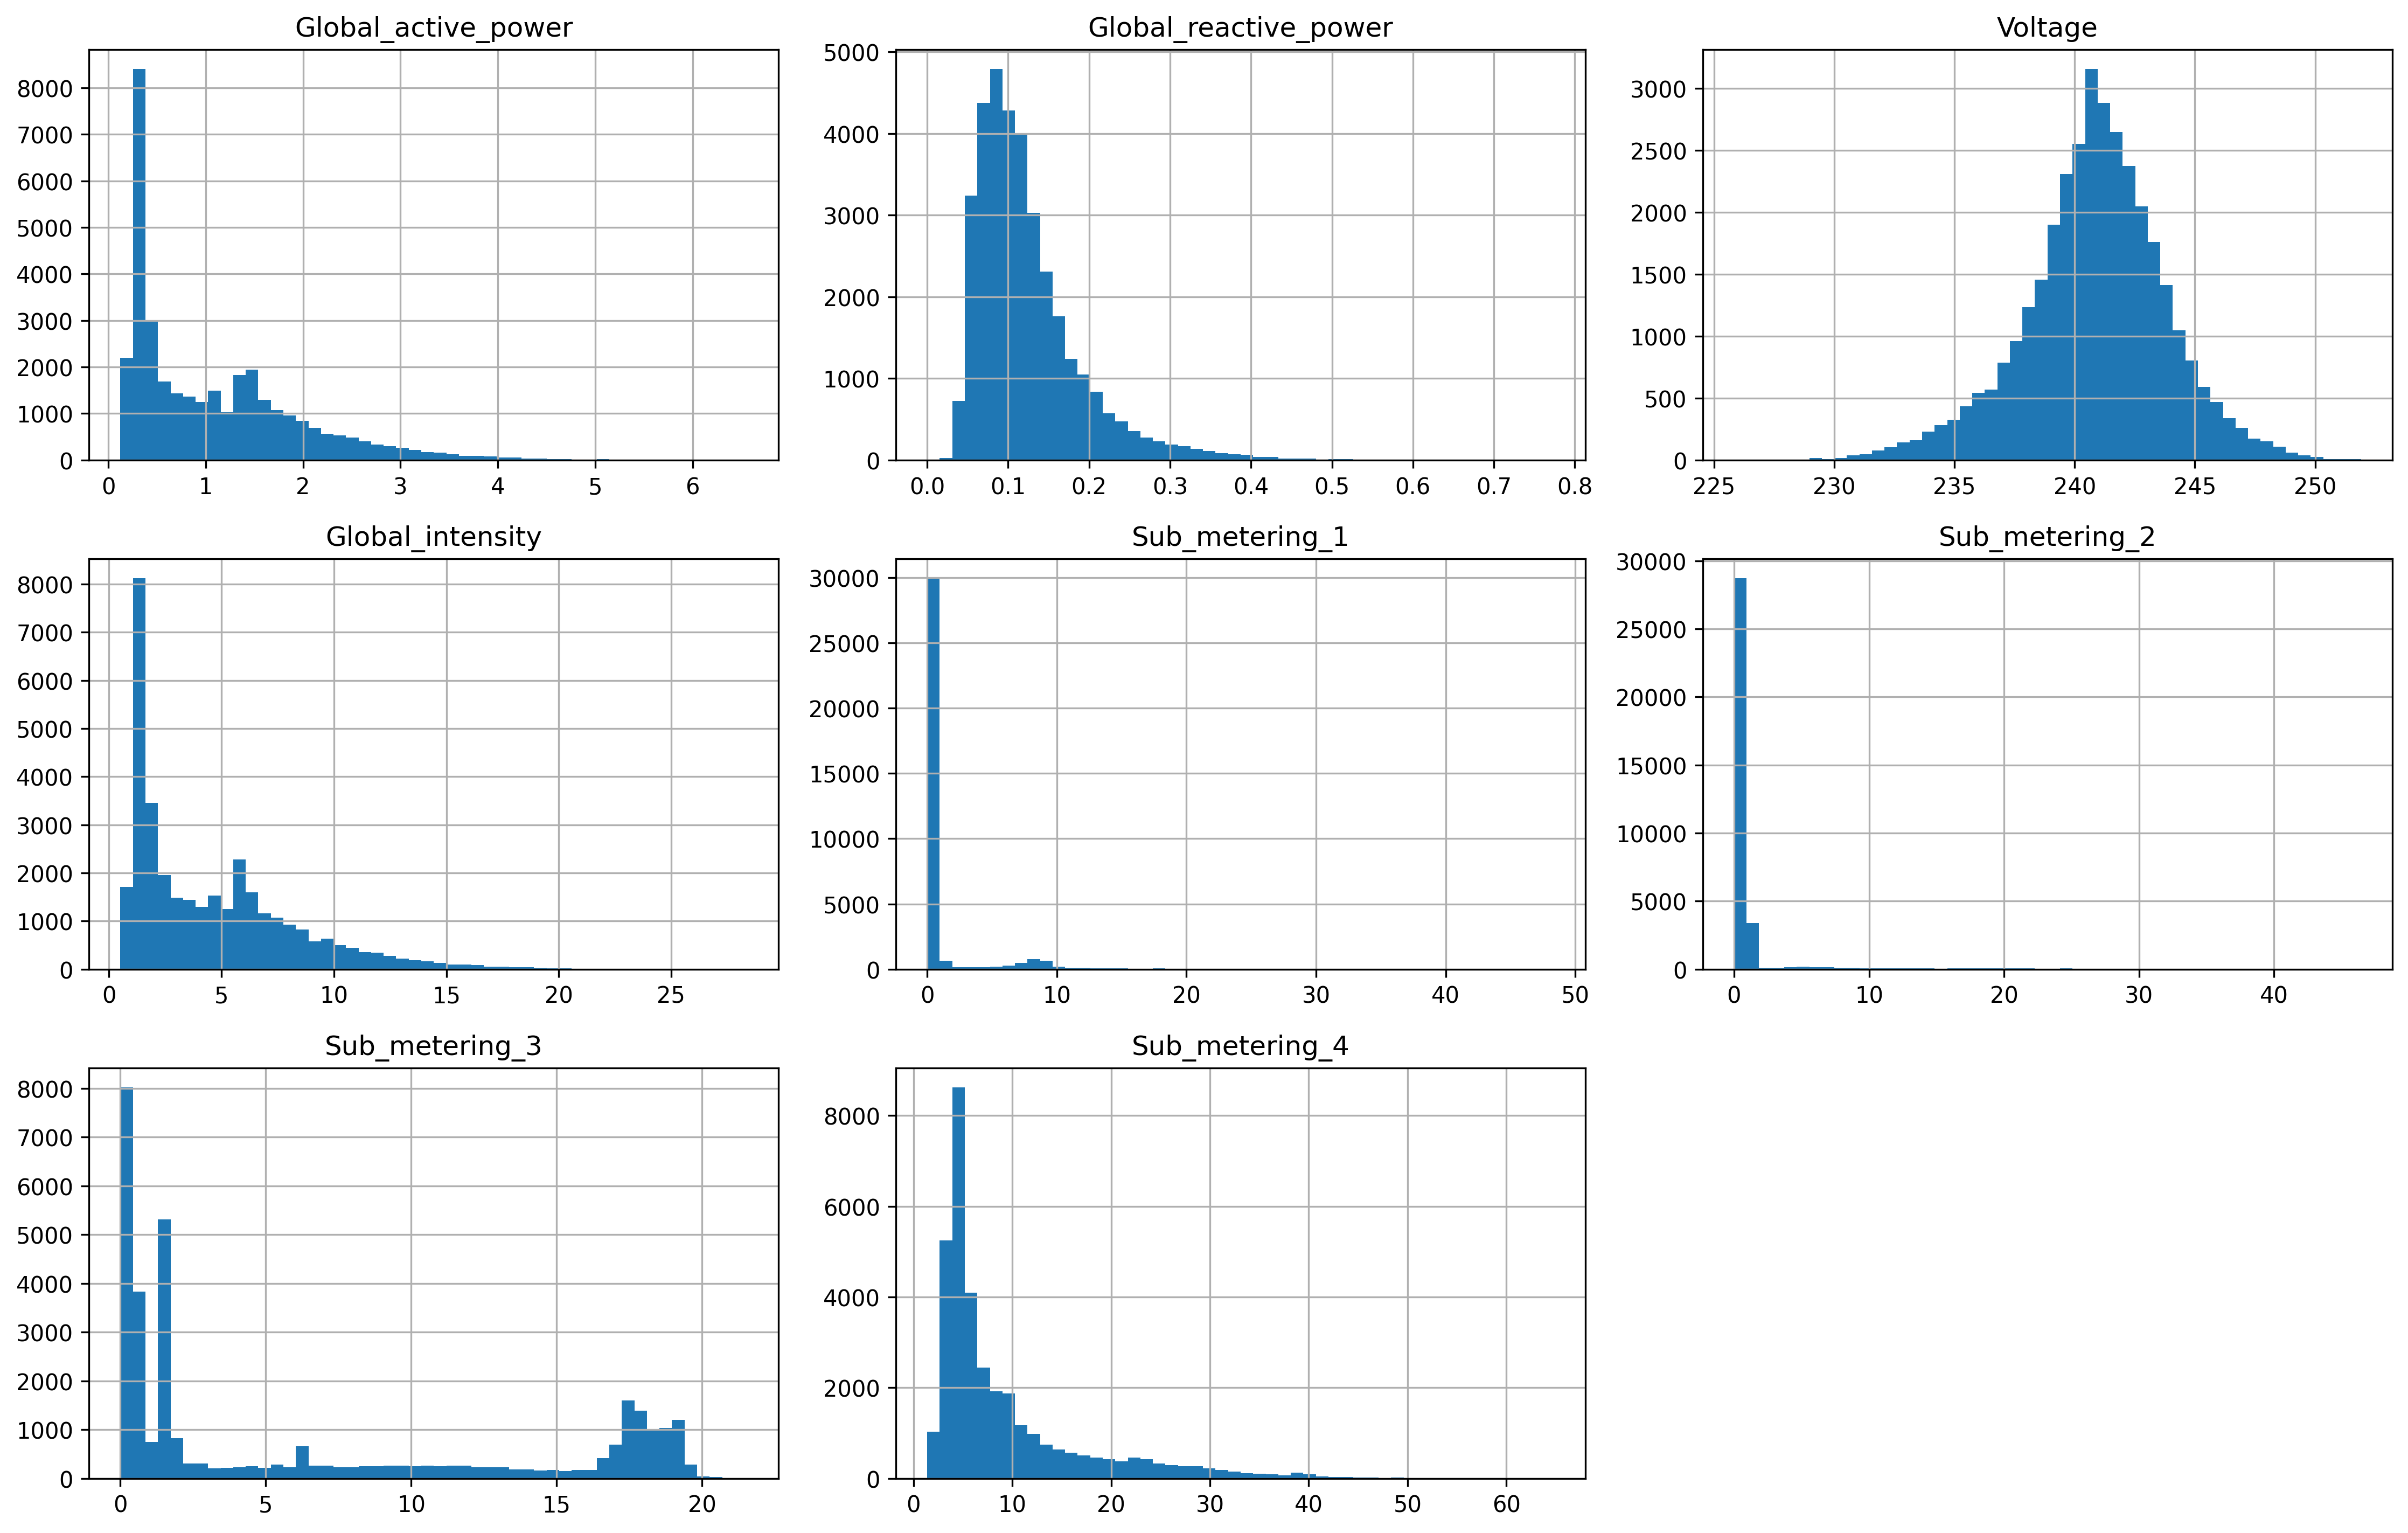

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



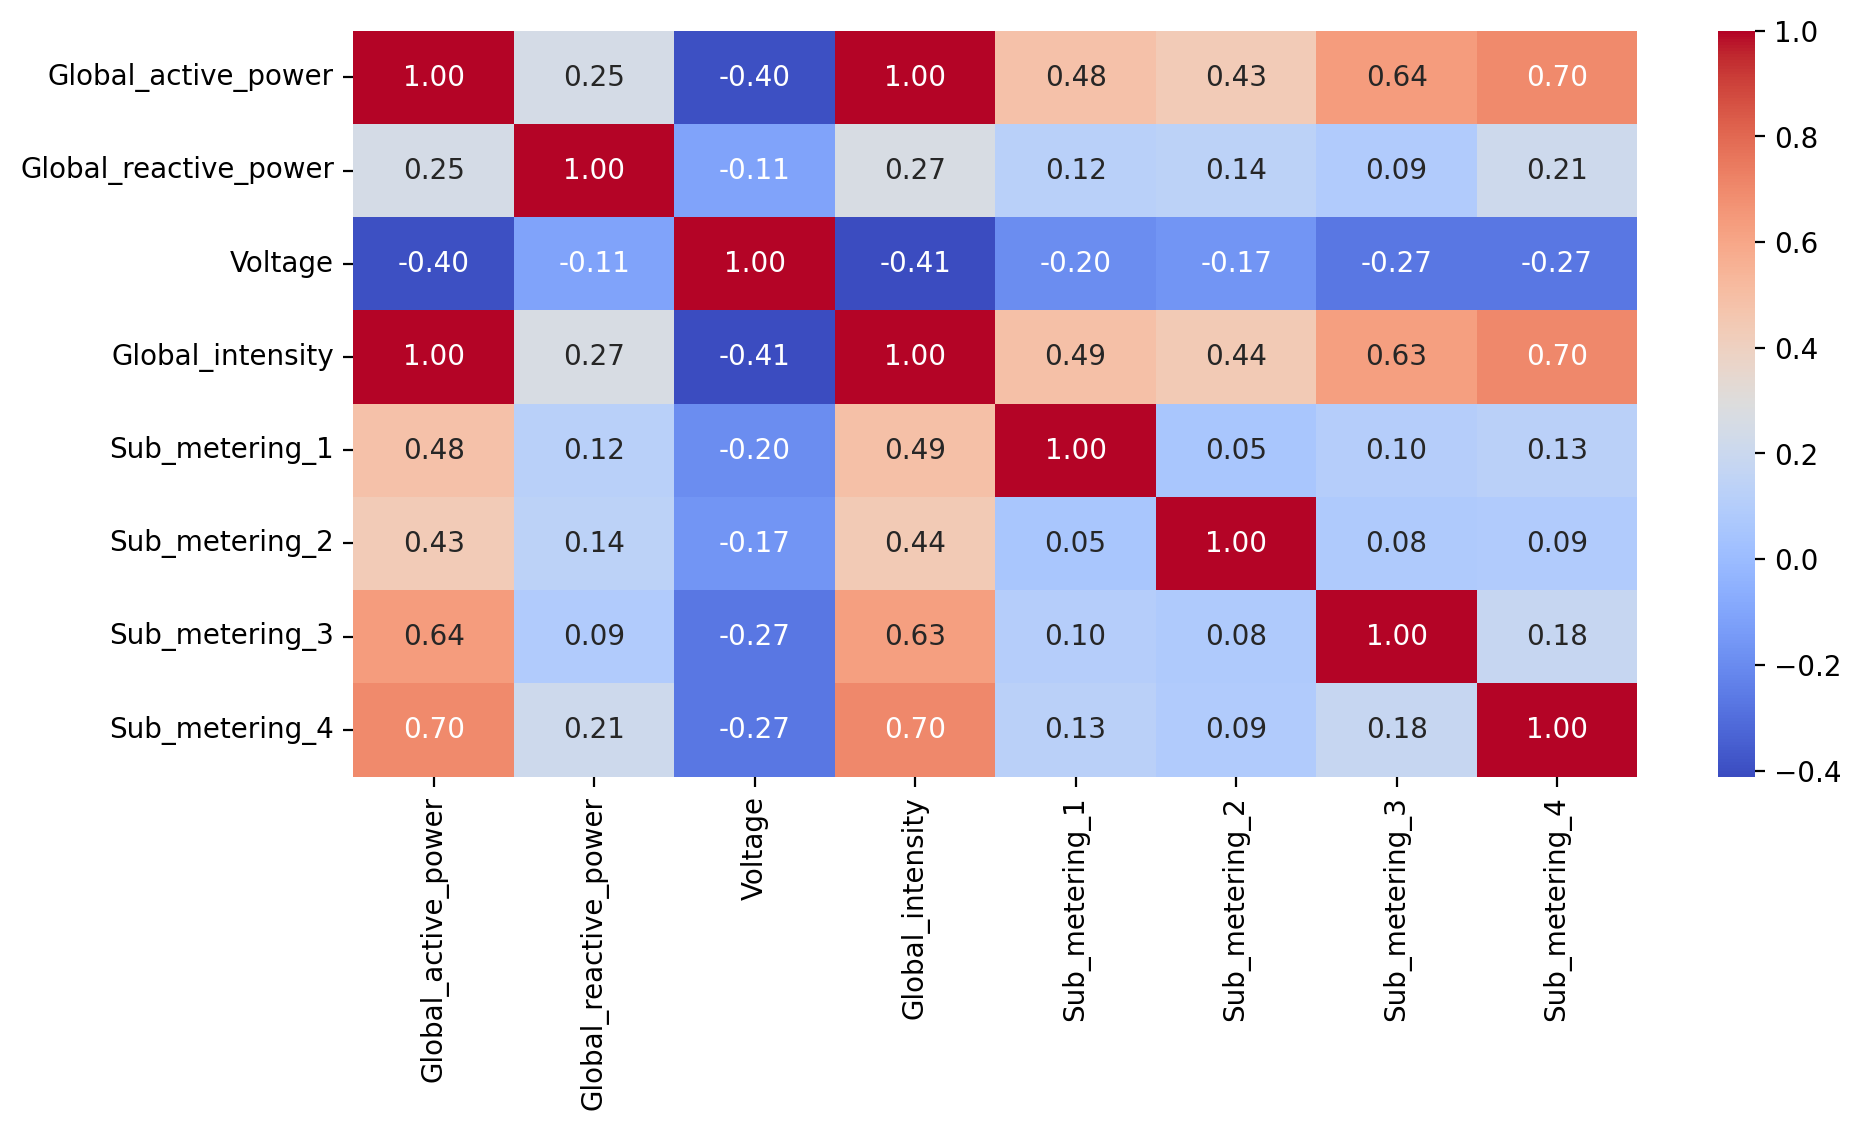

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [ ]:
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)
df1

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,0.0,0.416667,17.216667
...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,0.0,0.066667,0.000000


# Feature Engineering

In [ ]:
# Create new columns for hour, day, quarter, month, and year
#df1['hour'] = hourly_resampled.index.hour
#df1['month'] = hourly_resampled.index.month
#df1['quarter'] = hourly_resampled.index.quarter
#df1['year'] = hourly_resampled.index.year
#df1['week_of_year'] = hourly_resampled.index.isocalendar().week
#df1['day_of_week'] = hourly_resampled.index.dayofweek
#df1['day_of_month'] = hourly_resampled.index.day
#df1['day_of_year'] = hourly_resampled.index.dayofyear
#df1

## Data Normalization

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# See the scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, 0.        , 0.        ,
        0.        ]])

# Train-Test Splitting

In [ ]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((27661, 12, 6), (27661,), (6916, 12, 6), (6916,))

In [ ]:
X_train

array([[[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
         0.78241815],
        [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
         0.78267595],
        [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
         0.7741686 ],
        ...,
        [0.2273377 , 0.10103315, 0.7666315 , 0.        , 0.01220388,
         0.        ],
        [0.23897957, 0.10271201, 0.71656277, 0.        , 0.01651113,
         0.        ],
        [0.32498343, 0.12070598, 0.69132061, 0.        , 0.01220388,
         0.41221964]],

       [[0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
         0.78267595],
        [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
         0.7741686 ],
        [0.48854974, 0.09698666, 0.31598734, 0.        , 0.        ,
         0.77880897],
        ...,
        [0.23897957, 0.10271201, 0.71656277, 0.        , 0.01651113,
         0.        ],
        [0.32498343, 0.12070598, 0.69132061, 0.        , 0.012

# LSTM model

In [ ]:
# Create the LSTM model

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

'''model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
'''
'''model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu', return_sequences=False, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units=1, kernel_regularizer=l2(0.001)))
'''
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Model Summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,901 (167.58 KB)

 Trainable params: 42,901 (167.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.05)

# Fit the model
#history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


# Fit the model
history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/25
217/217 - 17s - 78ms/step - loss: 0.0235 - val_loss: 0.0106
Epoch 2/25
217/217 - 17s - 80ms/step - loss: 0.0186 - val_loss: 0.0099
Epoch 3/25
217/217 - 15s - 71ms/step - loss: 0.0166 - val_loss: 0.0094
Epoch 4/25
217/217 - 12s - 53ms/step - loss: 0.0152 - val_loss: 0.0088
Epoch 5/25
217/217 - 9s - 39ms/step - loss: 0.0143 - val_loss: 0.0085
Epoch 6/25
217/217 - 9s - 41ms/step - loss: 0.0138 - val_loss: 0.0083
Epoch 7/25
217/217 - 4s - 21ms/step - loss: 0.0132 - val_loss: 0.0081
Epoch 8/25
217/217 - 7s - 32ms/step - loss: 0.0128 - val_loss: 0.0080
Epoch 9/25
217/217 - 9s - 39ms/step - loss: 0.0126 - val_loss: 0.0079
Epoch 10/25
217/217 - 8s - 36ms/step - loss: 0.0122 - val_loss: 0.0078
Epoch 11/25
217/217 - 8s - 36ms/step - loss: 0.0120 - val_loss: 0.0077
Epoch 12/25
217/217 - 10s - 46ms/step - loss: 0.0119 - val_loss: 0.0076
Epoch 13/25
217/217 - 5s - 21ms/step - loss: 0.0117 - val_loss: 0.0075
Epoch 14/25
217/217 - 7s - 34ms/step - loss: 0.0115 - val_loss: 0.0075
Epoch 15/2

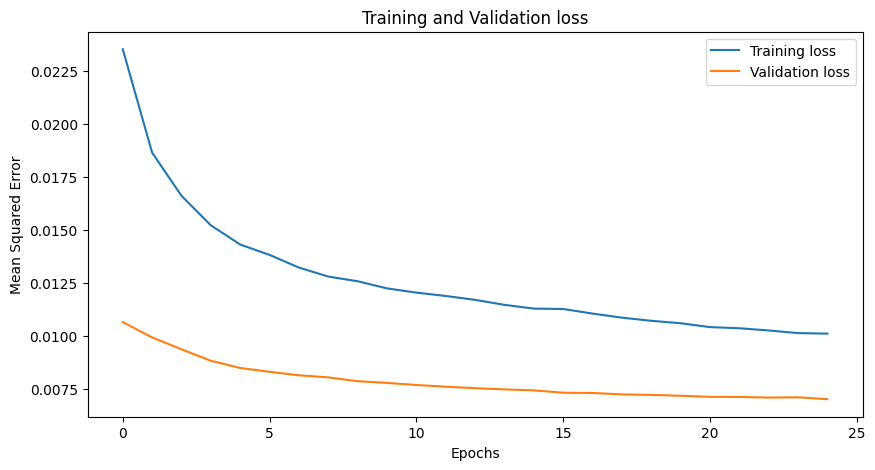

In [ ]:
# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.468
Train MSE: 0.393
Train RMSE: 0.627
Train R² score: 0.543

Test MAE: 0.414
Test MSE: 0.290
Test RMSE: 0.539
Test R² score: 0.445


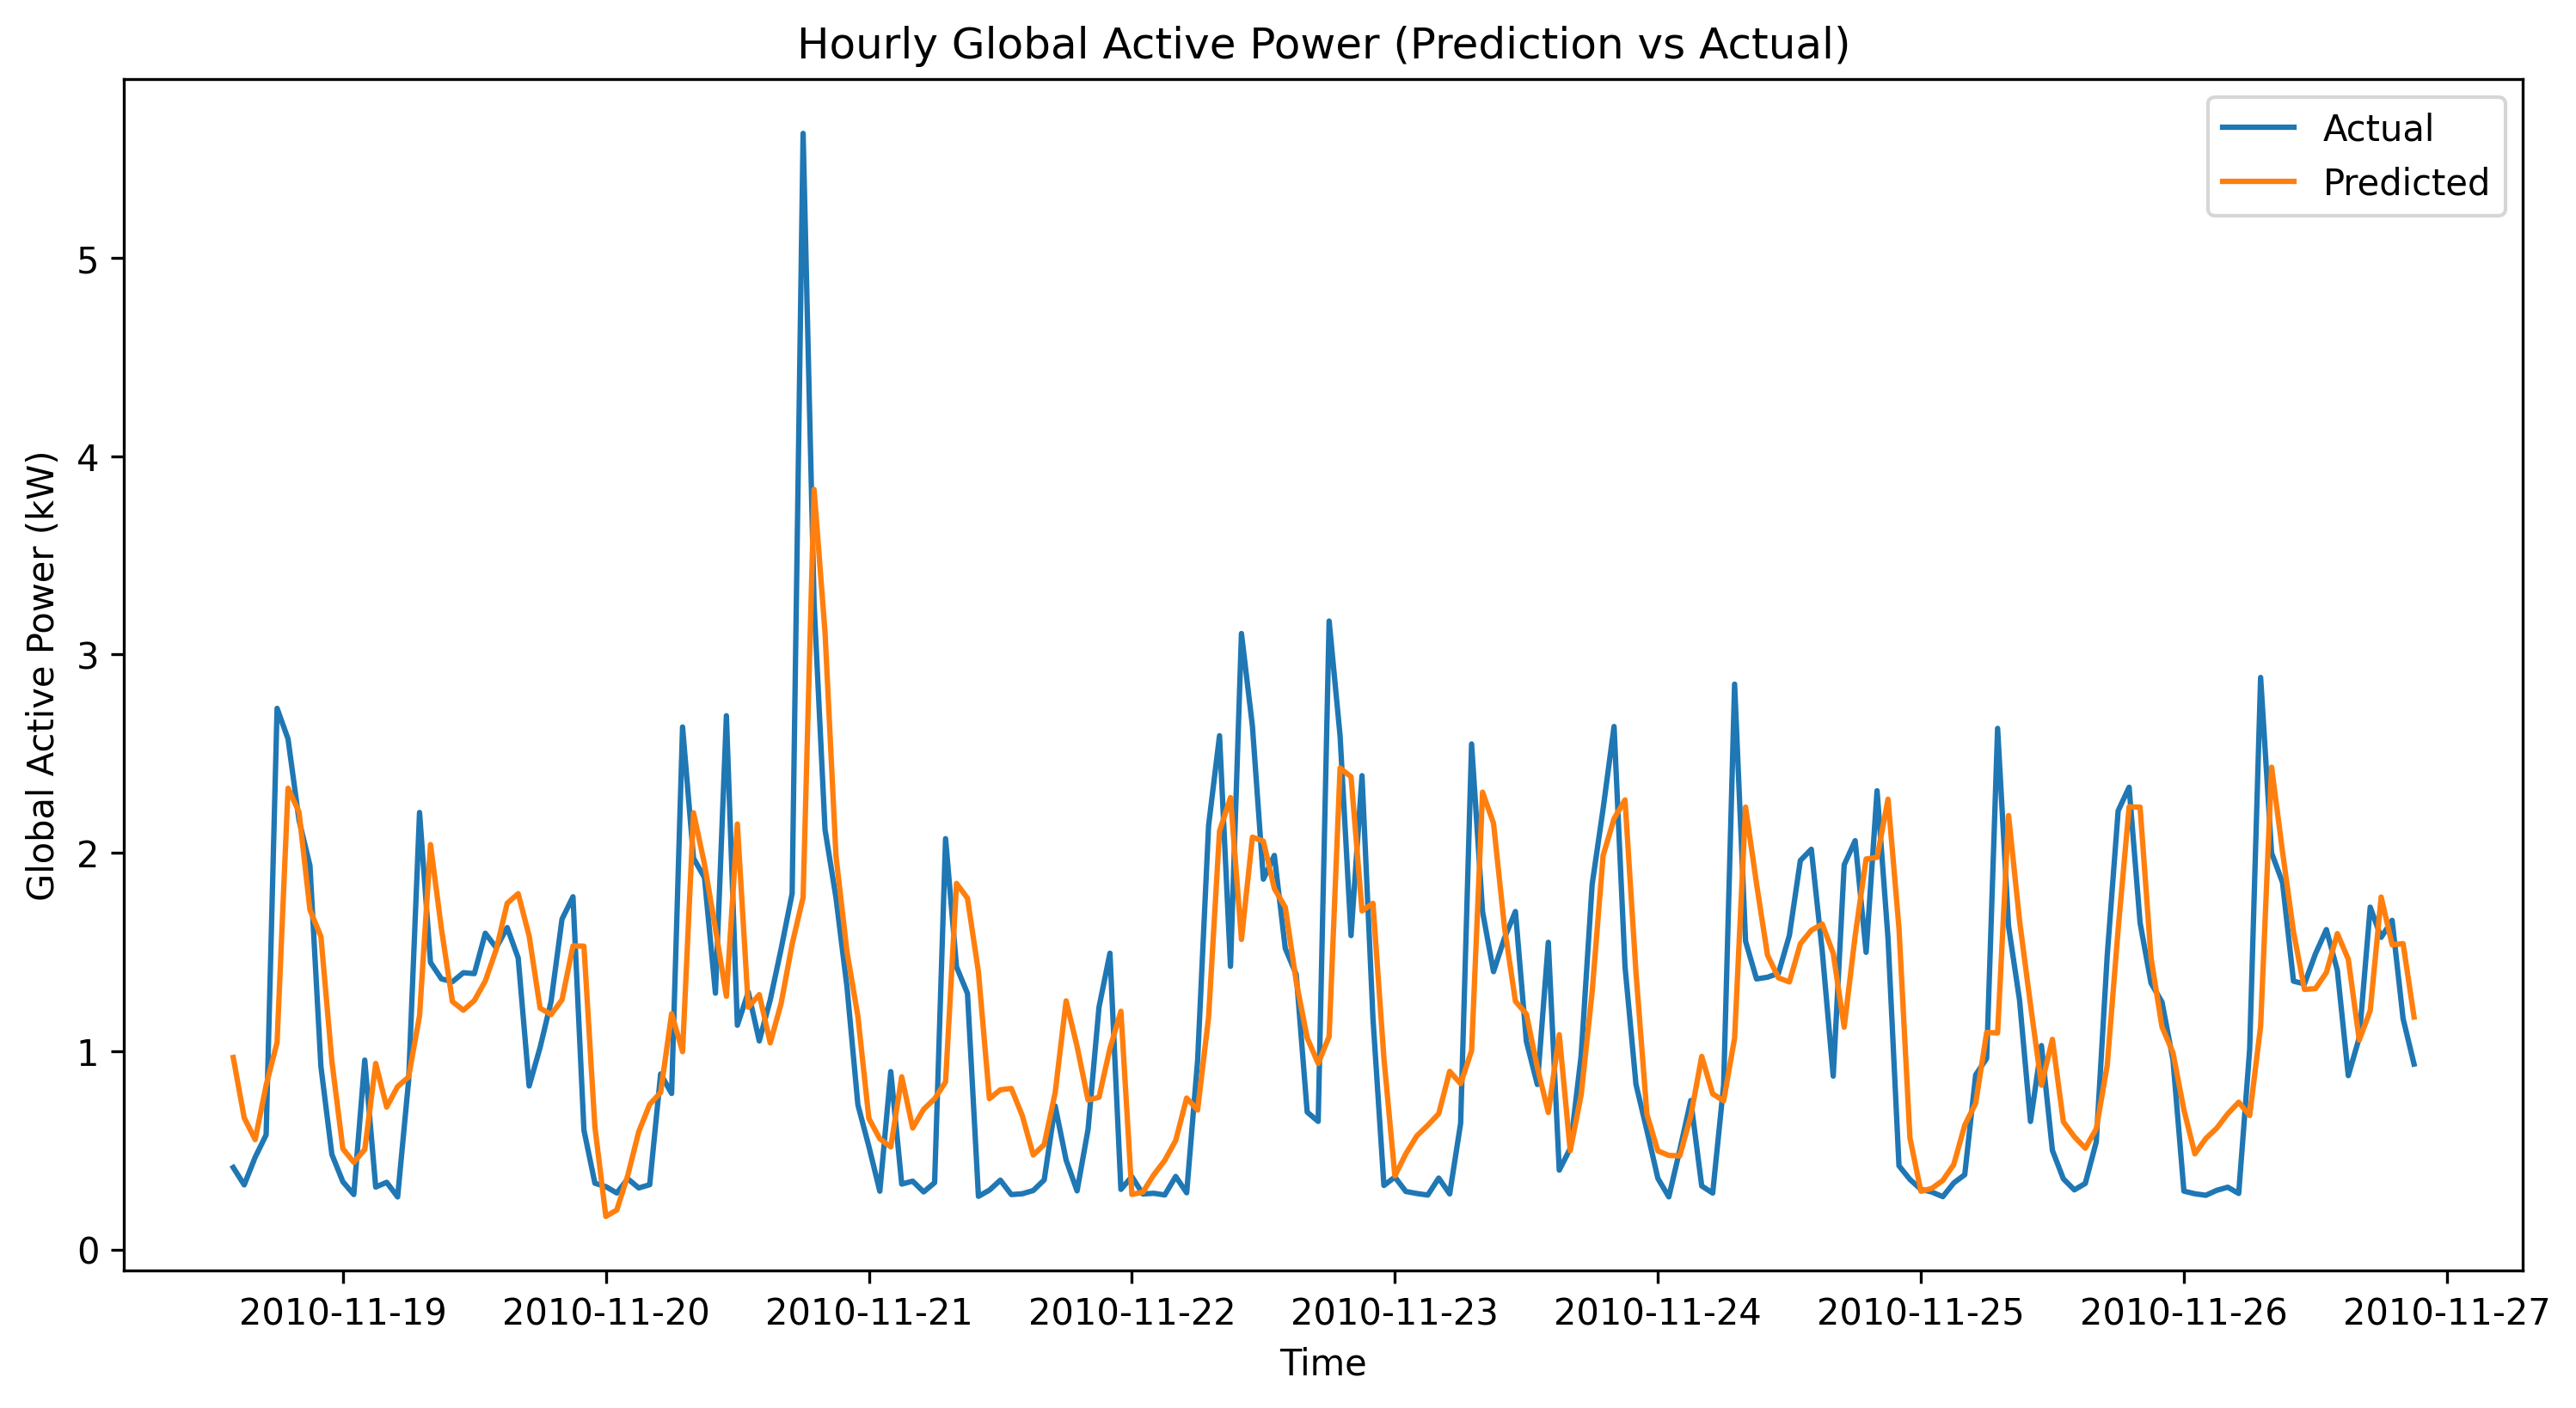

In [ ]:
# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/50
217/217 - 7s - 30ms/step - loss: 0.0332 - val_loss: 0.0116
Epoch 2/50
217/217 - 8s - 35ms/step - loss: 0.0220 - val_loss: 0.0107
Epoch 3/50
217/217 - 7s - 34ms/step - loss: 0.0192 - val_loss: 0.0101
Epoch 4/50
217/217 - 8s - 38ms/step - loss: 0.0175 - val_loss: 0.0097
Epoch 5/50
217/217 - 7s - 32ms/step - loss: 0.0162 - val_loss: 0.0092
Epoch 6/50
217/217 - 9s - 42ms/step - loss: 0.0152 - val_loss: 0.0090
Epoch 7/50
217/217 - 5s - 22ms/step - loss: 0.0145 - val_loss: 0.0087
Epoch 8/50
217/217 - 5s - 24ms/step - loss: 0.0139 - val_loss: 0.0085
Epoch 9/50
217/217 - 7s - 34ms/step - loss: 0.0134 - val_loss: 0.0084
Epoch 10/50
217/217 - 5s - 21ms/step - loss: 0.0131 - val_loss: 0.0083
Epoch 11/50
217/217 - 6s - 28ms/step - loss: 0.0129 - val_loss: 0.0082
Epoch 12/50
217/217 - 6s - 28ms/step - loss: 0.0125 - val_loss: 0.0080
Epoch 13/50
217/217 - 11s - 52ms/step - loss: 0.0122 - val_loss: 0.0079
Epoch 14/50
217/217 - 5s - 23ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 15/50
21

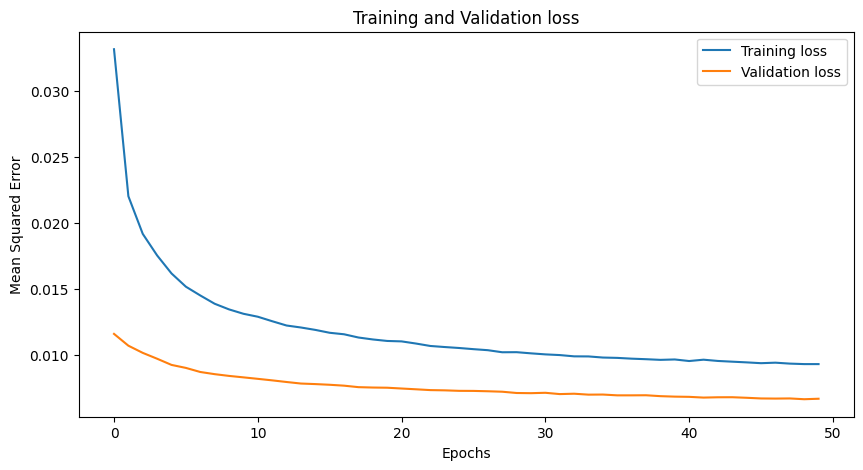

865/865 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.448
Train MSE: 0.366
Train RMSE: 0.605
Train R² score: 0.575

Test MAE: 0.399
Test MSE: 0.276
Test RMSE: 0.525
Test R² score: 0.474


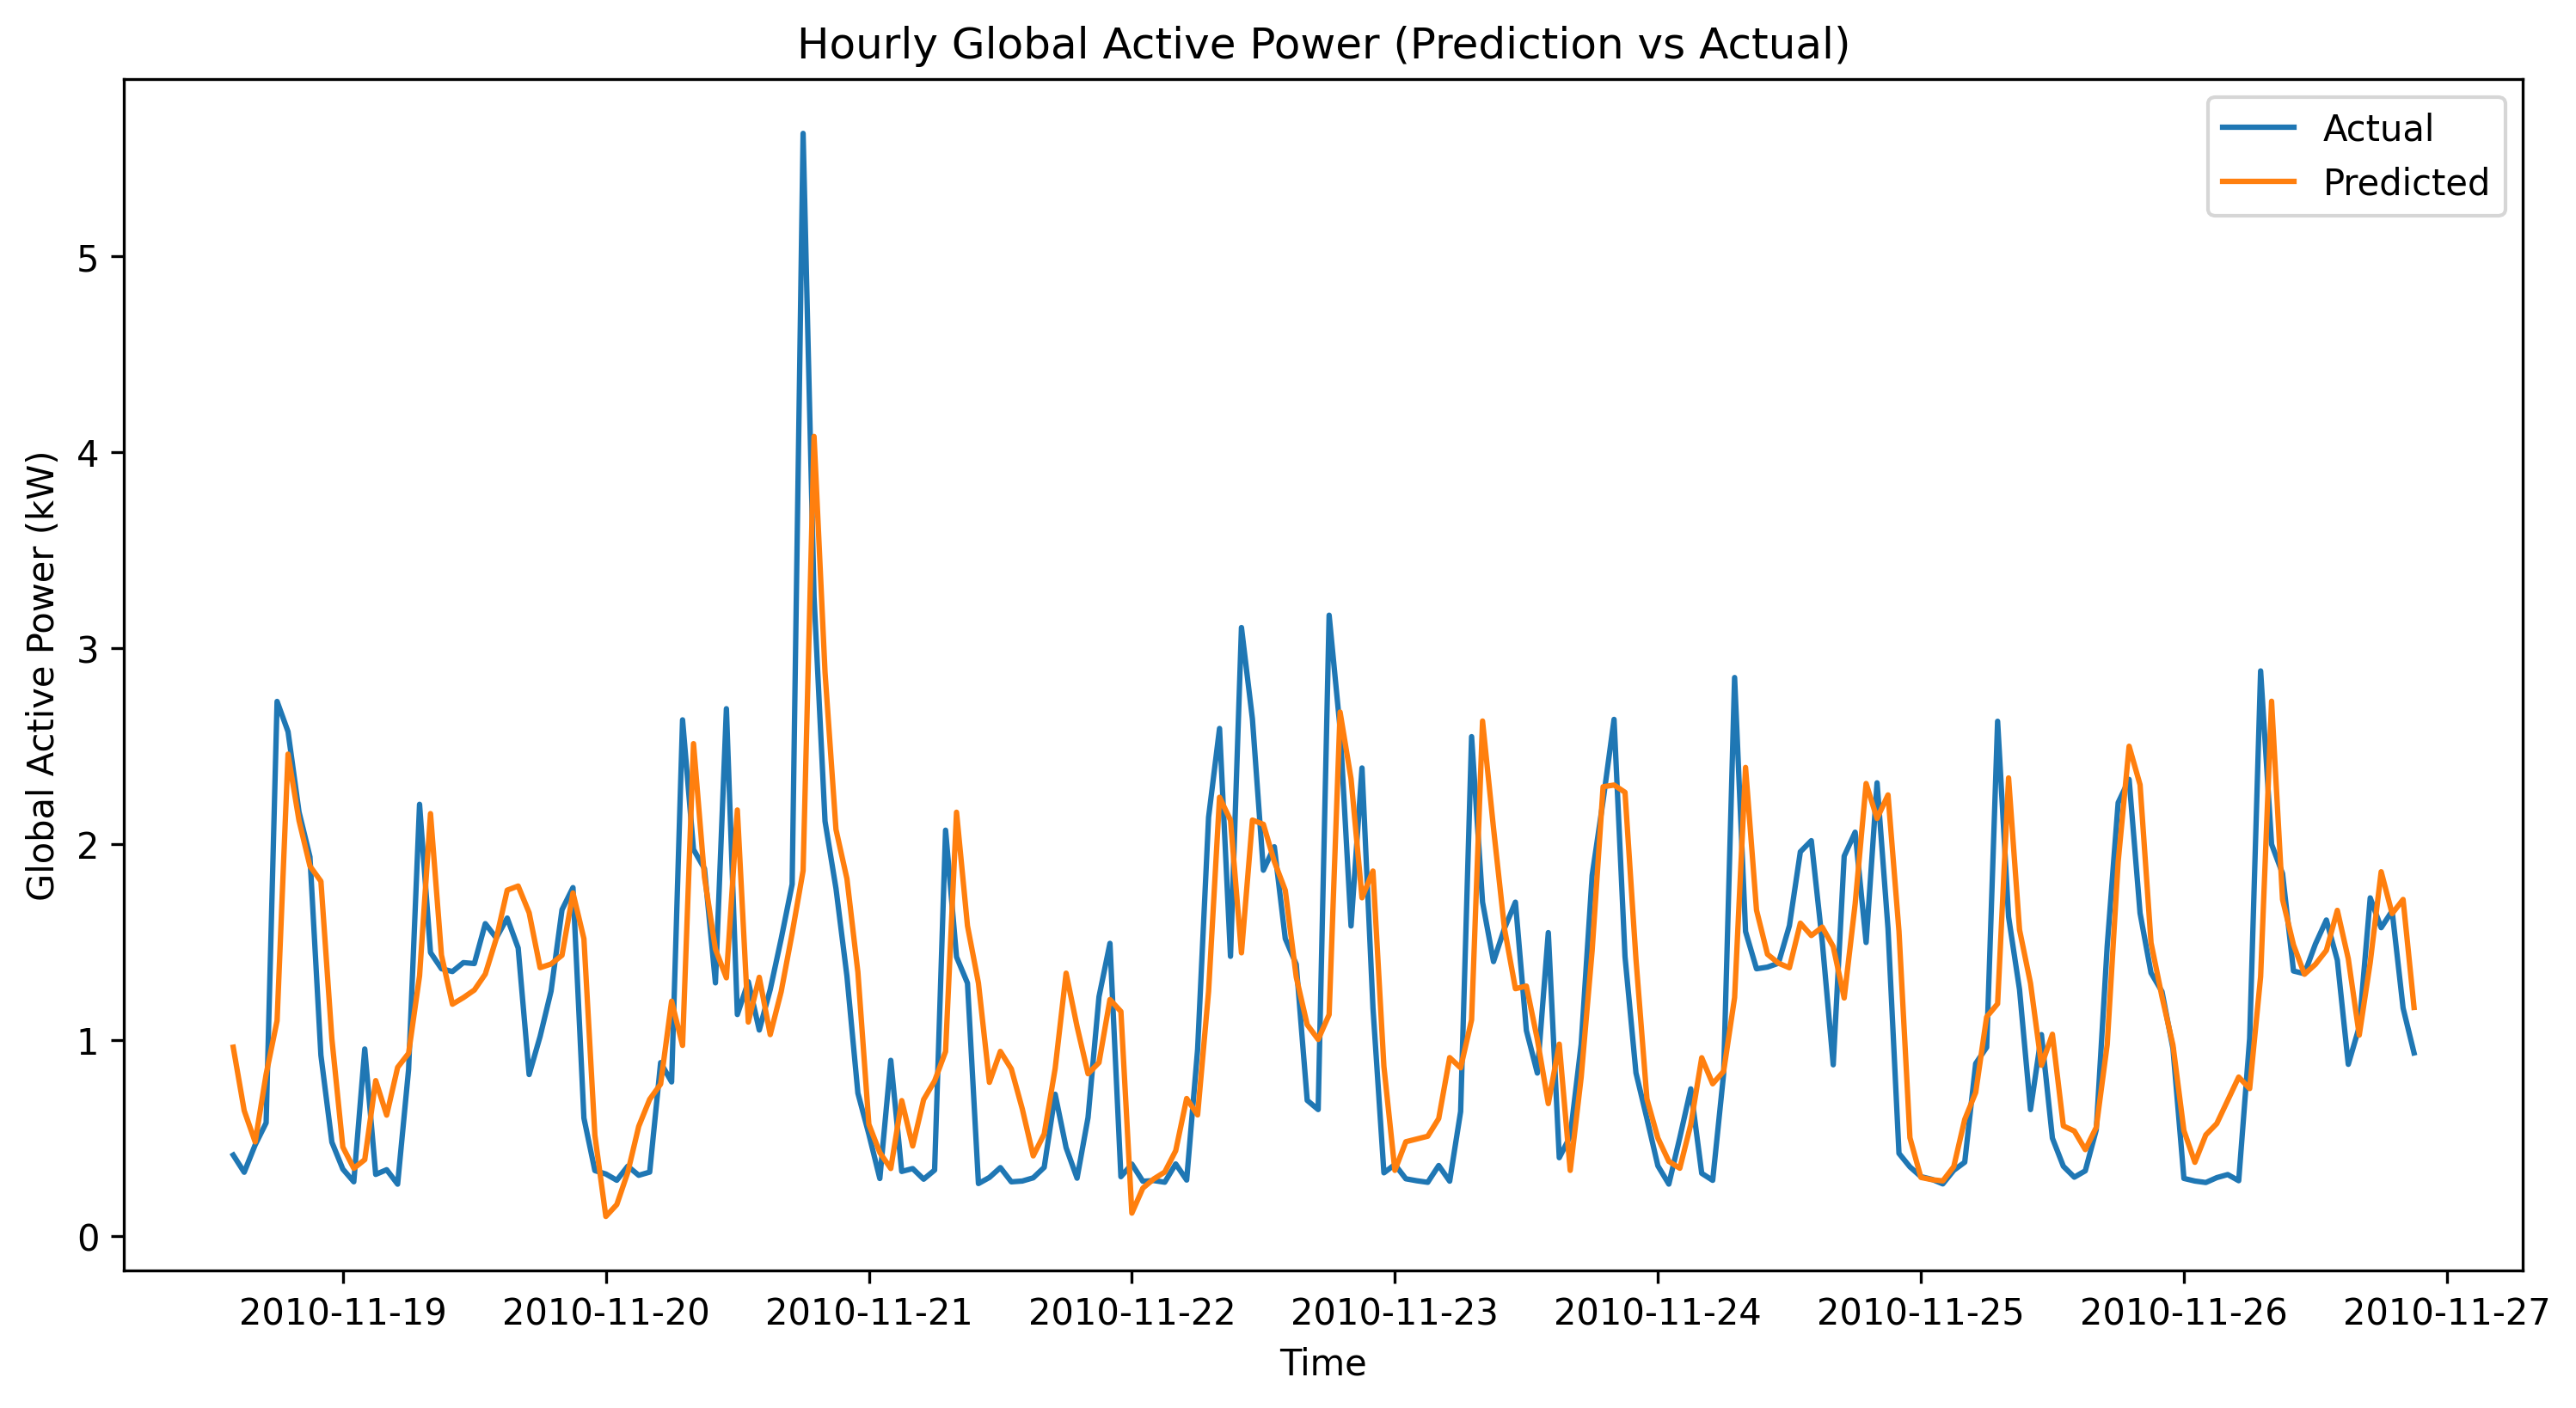

In [ ]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-3

Epoch 1/50
109/109 - 11s - 97ms/step - loss: 0.0356 - val_loss: 0.0134
Epoch 2/50
109/109 - 9s - 78ms/step - loss: 0.0247 - val_loss: 0.0120
Epoch 3/50
109/109 - 6s - 51ms/step - loss: 0.0221 - val_loss: 0.0111
Epoch 4/50
109/109 - 8s - 75ms/step - loss: 0.0202 - val_loss: 0.0105
Epoch 5/50
109/109 - 8s - 71ms/step - loss: 0.0190 - val_loss: 0.0100
Epoch 6/50
109/109 - 8s - 73ms/step - loss: 0.0178 - val_loss: 0.0096
Epoch 7/50
109/109 - 5s - 42ms/step - loss: 0.0169 - val_loss: 0.0092
Epoch 8/50
109/109 - 6s - 54ms/step - loss: 0.0160 - val_loss: 0.0089
Epoch 9/50
109/109 - 4s - 33ms/step - loss: 0.0156 - val_loss: 0.0087
Epoch 10/50
109/109 - 4s - 33ms/step - loss: 0.0148 - val_loss: 0.0085
Epoch 11/50
109/109 - 6s - 57ms/step - loss: 0.0144 - val_loss: 0.0083
Epoch 12/50
109/109 - 8s - 70ms/step - loss: 0.0141 - val_loss: 0.0082
Epoch 13/50
109/109 - 8s - 77ms/step - loss: 0.0137 - val_loss: 0.0081
Epoch 14/50
109/109 - 4s - 33ms/step - loss: 0.0133 - val_loss: 0.0081
Epoch 15/50
10

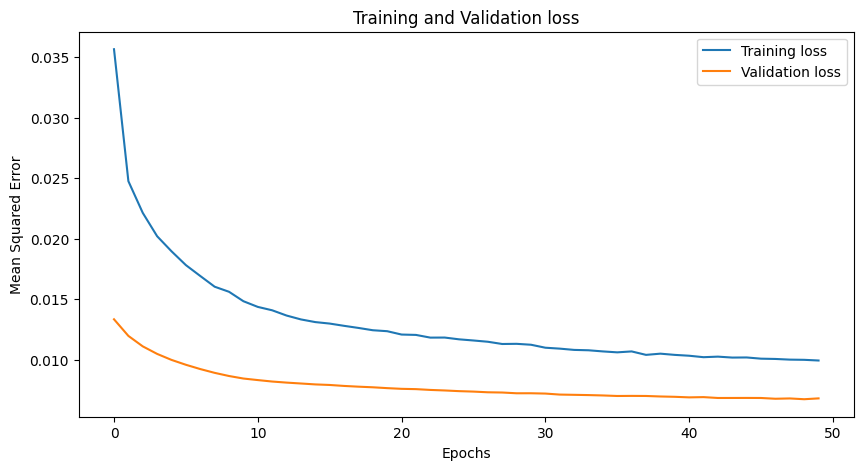

865/865 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.457
Train MSE: 0.383
Train RMSE: 0.619
Train R² score: 0.555

Test MAE: 0.403
Test MSE: 0.283
Test RMSE: 0.532
Test R² score: 0.460


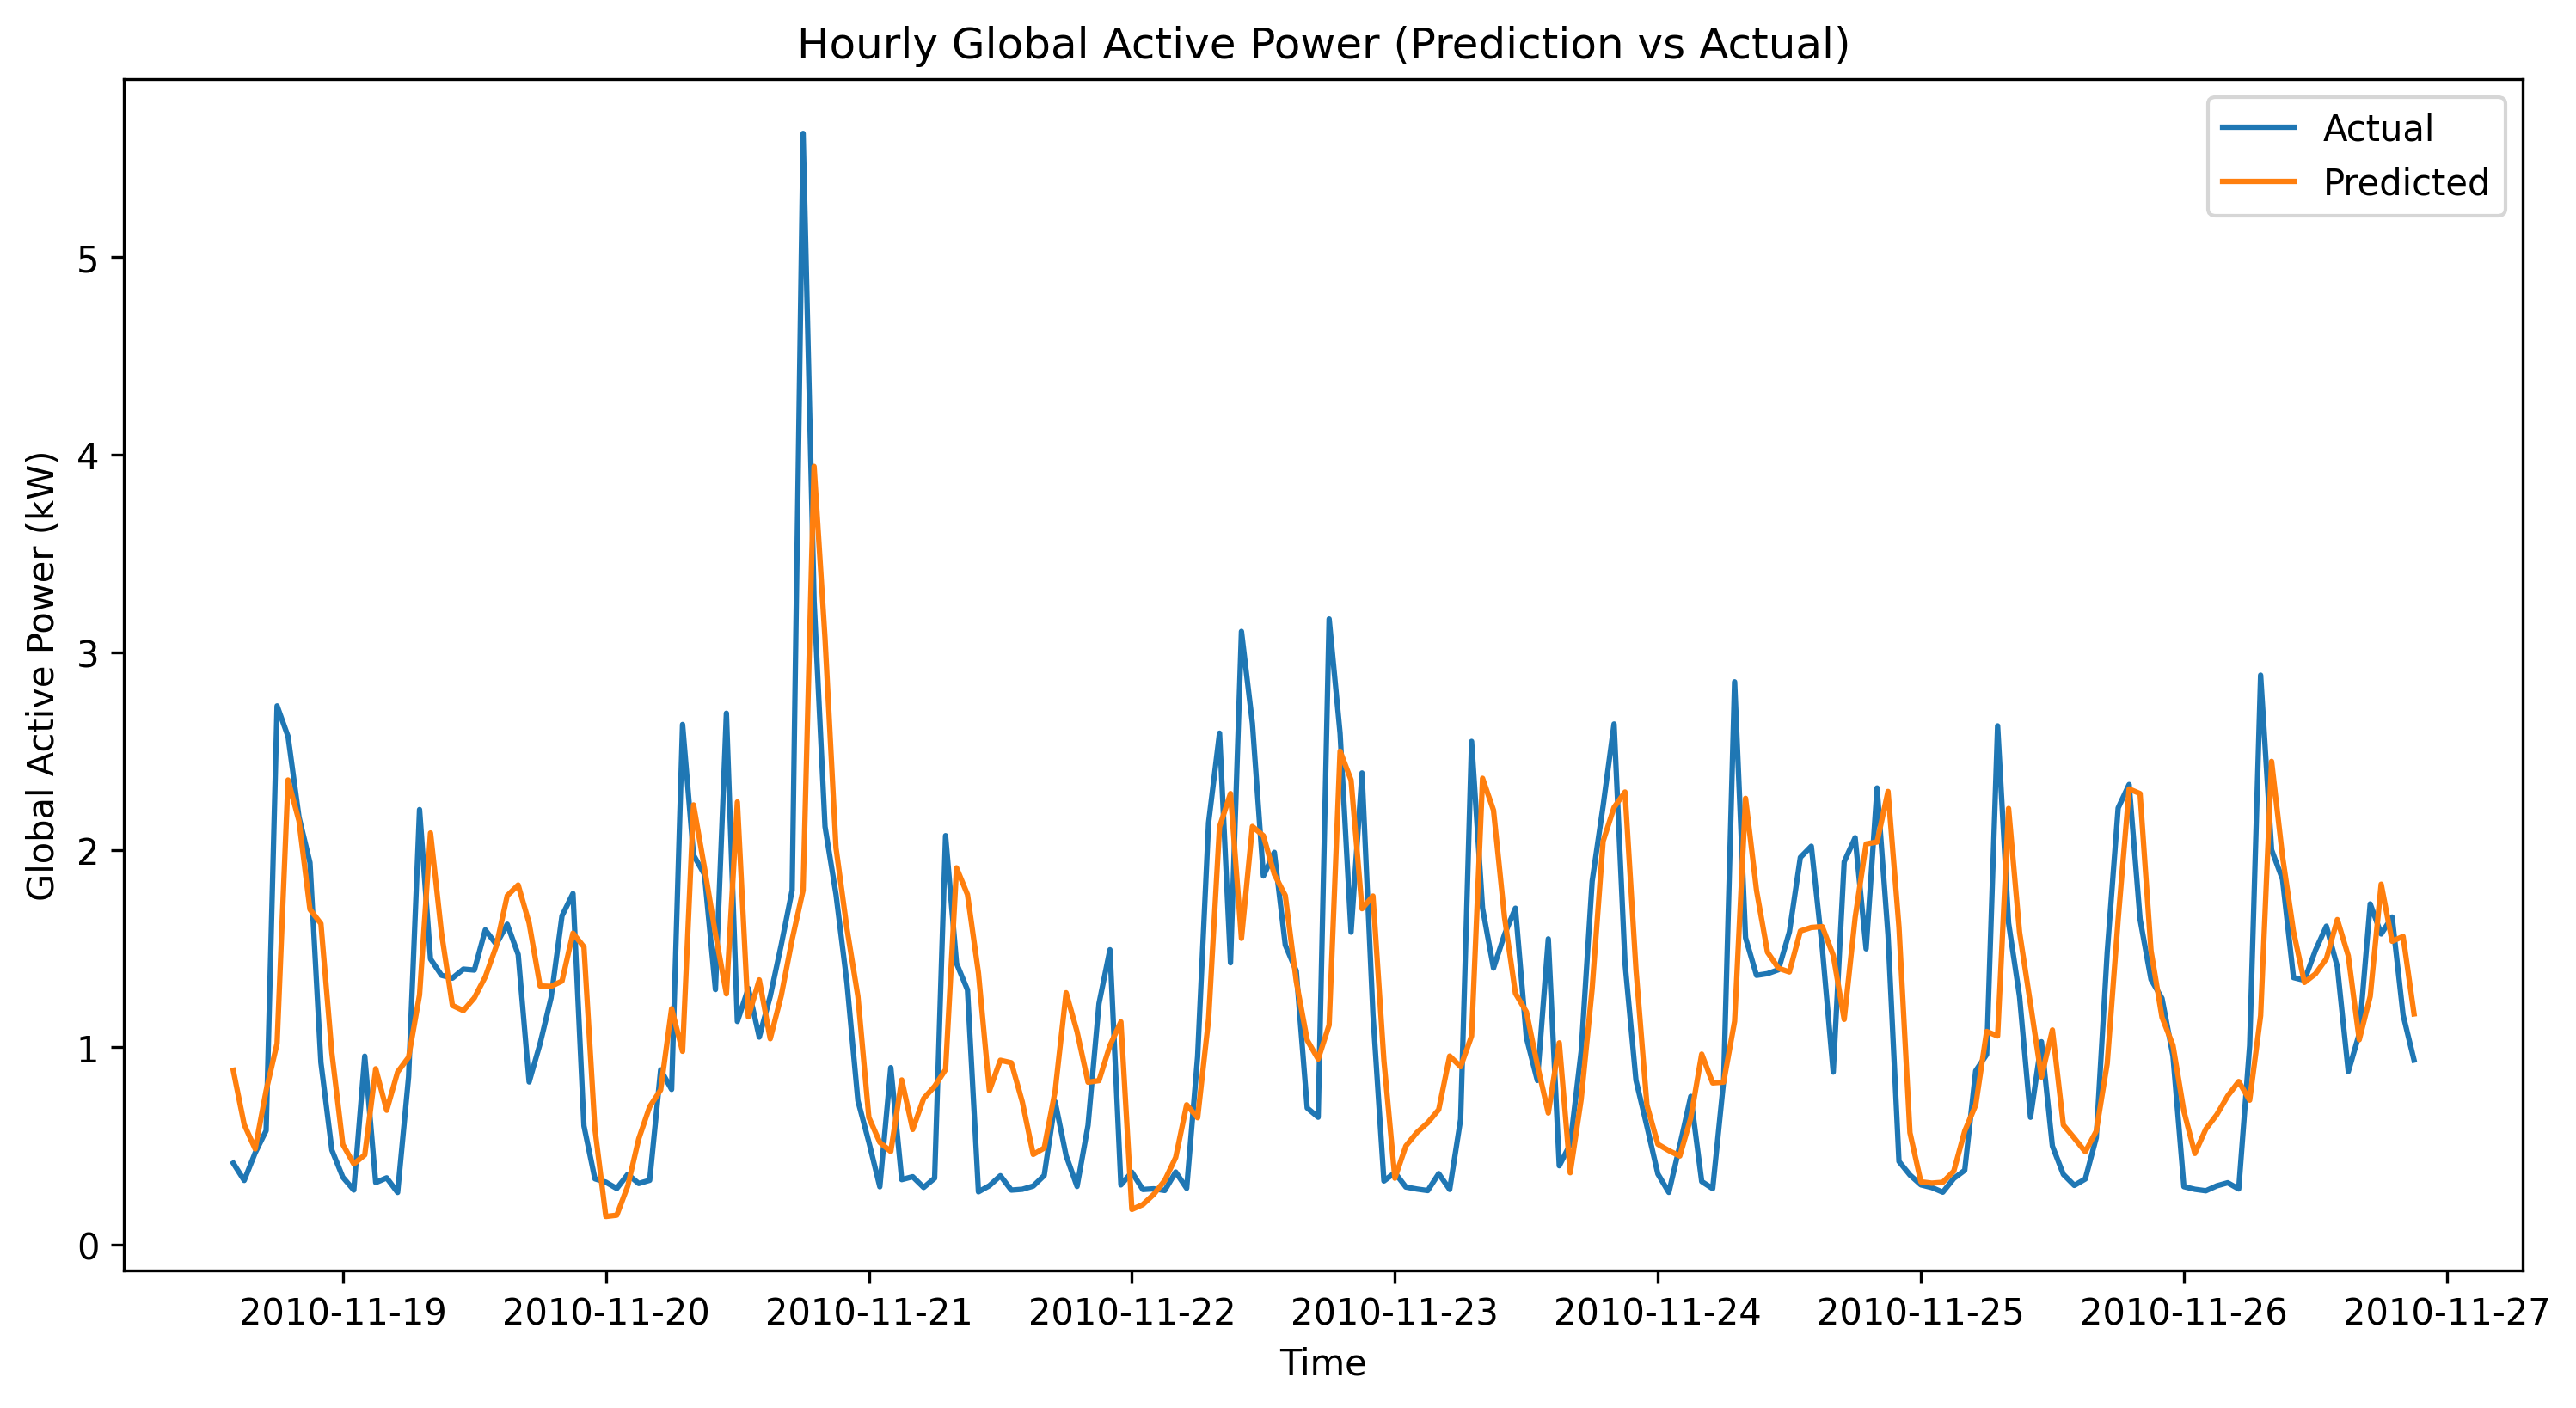

In [ ]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()